In [1]:
from wgangp.db_utils import *
from acf_utils import *
from utility import *

/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorf

In [3]:
run = 3
number = 19999
path = f'/scratch/scarpolini/lagrangian/wgangp/runs/{run}/{number}_gen.h5'
gen = load_model(path)
trajs = gen.predict(np.random.normal(0, 1, size=(50000, 100)))
np.save(f'wgangp/runs/{run}/gen_trajs', trajs)

W0525 23:55:22.684873 47689188896256 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [6]:
path = f'/scratch/scarpolini/lagrangian/wgangp/runs/{run}/gen_trajs.npy'
gen = np.load(path)

M = gen.max()
m = gen.min()
print('massimo, minimo: ',M,m)

#db = np.load('/scratch/scarpolini/databases/velocities.npy')[:,:,0]
#M = db.max() 
M = 10.273698864467972
#m = db.min()
m = -9.970374739869616
semidisp = (M-m)/2.
media = (M+m)/2.
gen = gen*semidisp + media
print('veri',M,m)
M = gen.max()
m = gen.min()
print('generati',M,m)

massimo, minimo:  0.799757 -0.83415073
veri 10.273698864467972 -9.970374739869616
generati 8.246832 -8.291642


# Predictor

# Exit time

computing exit time for r=54, 49999 Saved!


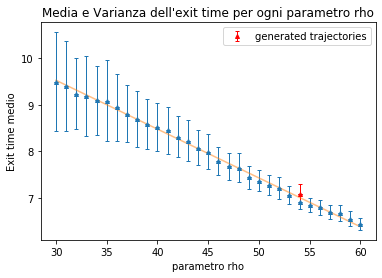

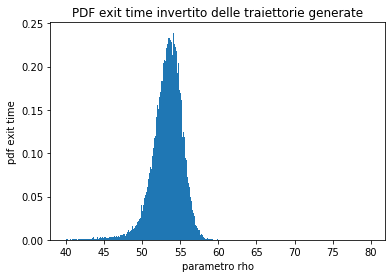

In [4]:
# CALCOLO EXIT TIME SU TRAIETTORIE GENERATE
gen_exit_time(paths,0.5)

# EXIT TIME DELLE TRAIETTORIE REALI
soglia = 0.5
rv = range(30,61,1)
paths_et_real = [f'/scratch/scarpolini/databases/exit_time_{soglia:.2f}_lorenz_{r:.1f}.npy' for r in rv]
paths_et_gen = '/scratch/scarpolini/databases/gen_exit_time_0.50_lorenz_54.0.npy'
et = [np.load(path) for path in paths_et_real]
labels = [str(r) for r in rv]
means = [np.mean(x) for x in [x[0] for x in et]]
stds = [np.std(x) for x in [x[0] for x in et]]

# FIT
from scipy.optimize import curve_fit
def retta(x, a, b):
    return a*x + b
rvv = np.array(range(30,70,10))
a, b = curve_fit(retta, rv, means)
fit = retta(rv, a=a[0], b=a[1])
def inversa(y):
    return (1./a[0])*y - a[1]/a[0]

# GEN TRAJECTORIES
gen_et = np.load(paths_et_gen)
gen_mean, gen_std = np.mean(gen_et), np.std(gen_et)
# PLOTTO REALI
l, caps, c = plt.errorbar(rv, means, stds, lw=0, marker='^', ms=4, elinewidth=1, uplims=True, lolims=True, capsize=2)
for cap in caps:
    cap.set_marker("_")
# PLOTTO GENERATE
l, caps, c = plt.errorbar([54.0], gen_mean, gen_std, lw=0, marker='^', ms=4, color='red', elinewidth=1, uplims=True, lolims=True, capsize=2, label='generated trajectories')
for cap in caps:
    cap.set_marker("_")    

# PLOT ET
plt.plot(rv, fit, alpha = 0.5)
plt.xlabel('parametro rho')
plt.ylabel('Exit time medio')
plt.title("Media e Varianza dell'exit time per ogni parametro rho")
plt.legend()
plt.savefig("plots/gan_test_et.png", dpi=100, format='png')
plt.show()

# PLOT ET PDF
inv_et_gen = inversa(gen_et).reshape(50000)
plt.title('PDF exit time invertito delle traiettorie generate')
plt.hist(inv_et_gen, bins=np.arange(40,80,0.1), density=True)
plt.xlabel('parametro rho')
plt.ylabel('pdf exit time')
plt.savefig("plots/gan_test_et_pdf.png", dpi=100, format='png')
plt.show()

# Gradients

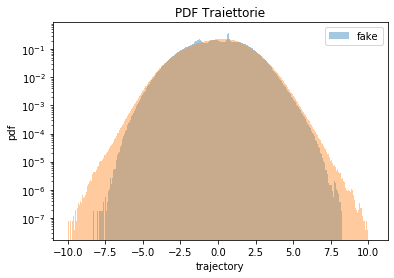

In [10]:
plt.title('PDF Traiettorie')
plt.hist(gen.flatten(), bins=300, label='fake', alpha=0.4, density=True)
hist, bin_edges = load_pdf('data/pdf_vx')
plt.hist(bin_edges[:-1], bin_edges, weights=hist, alpha=0.4, label='True')
plt.yscale('log')
plt.legend()
plt.xlabel('trajectory')
plt.ylabel('pdf')
plt.savefig('plots/gan_test_d0.png', fmt='png', dpi=100)
plt.show()

In [8]:
gm = np.gradient(gen,axis=1)

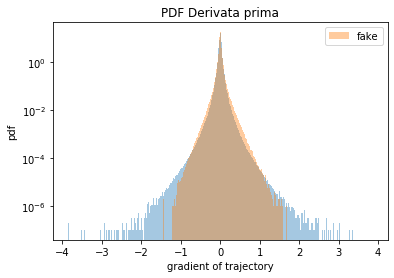

In [9]:
plt.title('PDF Derivata prima')
hist, bin_edges = load_pdf('data/pdf_ax')
plt.hist(bin_edges[:-1], bin_edges, weights=hist, alpha=0.4)
plt.hist(gm.flatten(), bins=300, label='fake', alpha=0.4, density=True)
plt.legend()
plt.yscale('log')
plt.xlabel('gradient of trajectory')
plt.ylabel('pdf')
plt.savefig('plots/gan_test_d1.png', fmt='png', dpi=100)
plt.show()

# Plot Traiettorie Generate e Reali

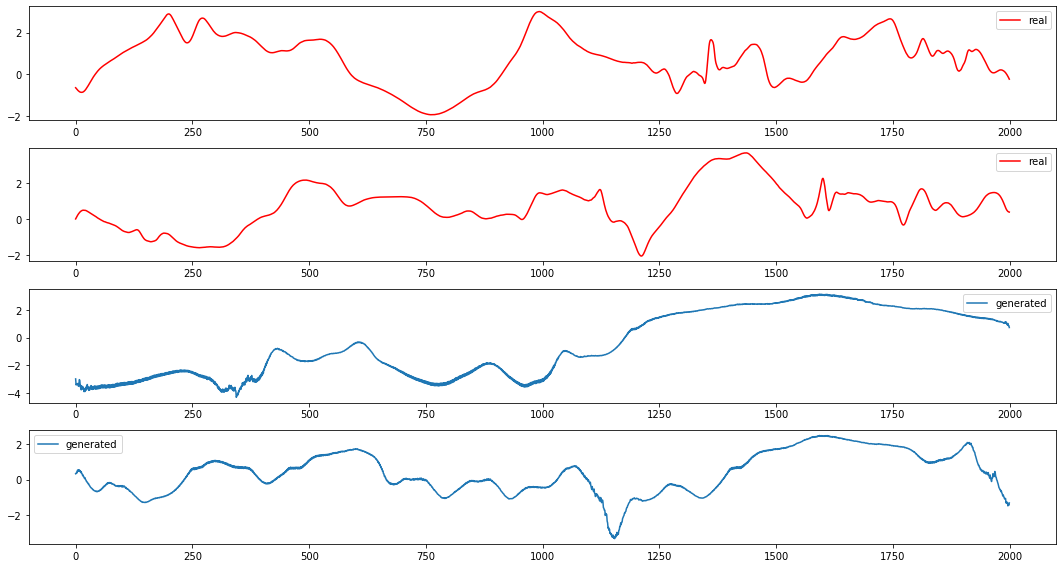

In [11]:
idx1 = np.random.randint(0, db.shape[0], 2)
idx2 = np.random.randint(0, gen.shape[0], 2)
trajs = db[idx1]
gen_trajs = gen[idx2]
plt.figure(figsize=(15, 2*len(trajs)+2*len(gen_trajs)))
plt.title('esempi di traiettorie vere e generate')

for i, traj in enumerate(trajs):
    plt.subplot(len(trajs)+len(gen_trajs), 1, i+1)
    plt.plot(traj, color='red', label='real')
    plt.legend()

for i, traj in enumerate(gen_trajs):
    plt.subplot(len(trajs)+len(gen_trajs), 1, i+1+len(trajs))
    plt.plot(traj, label='generated')
    plt.legend()

plt.tight_layout()
plt.savefig('plots/gan_test_trajs.png', fmt='png', dpi=100)
plt.show()